In [8]:
import os
import torch
import pandas as pd
from no_training import (
    sample_images,
    predict_images,
    process_points_results, 
    log_results, 
    get_data, 
    process_shapes_results,
    predict_images_without_deciding
)

%matplotlib inline
import seaborn as sns
blue_yellow = ["#FFD700", "#0000FF"]
# blue_yellow.reverse()
sns.set_palette(blue_yellow)

device = torch.device("cpu")
dtype = torch.float32

num_passes = 4
pairs_num = 100

In [2]:
connections, shuffled_connections, all_neurons, neuron_data, all_coords = get_data()
head_direction = pd.read_csv(
    "adult_data/head_direction_neurons.csv", dtype={"root_id": "string"}
)
neurons_in_coords = all_neurons.merge(all_coords, on="root_id", how="right")[
    ["root_id", "cell_type"]
].fillna("Unknown")

# Set all cell_types with less than "20" samples to "others"
n = 20

counts = neurons_in_coords["cell_type"].value_counts()

small_categories = counts[counts < n].index
neurons_in_coords["cell_type"] = neurons_in_coords["cell_type"].apply(
    lambda x: "others" if x in small_categories else x
)

In [18]:
base_dir = "images"
sub_dirs = ["head_rotation"]
sampled_images = [os.path.join(base_dir, sub_dirs[0], a) for a in sorted(os.listdir(f"{base_dir}/{sub_dirs[0]}"))]

In [52]:
from model_inspection_funcs import neuron_data_from_image, propagate_data_with_steps

temp = all_coords

img = sampled_images[0]
activated_data = neuron_data_from_image(img, neuron_data)
new_activation = activated_data[["root_id", "activation"]]
activation = new_activation
activation = propagate_data_with_steps(activation, connections, 0)
temp = temp.merge(activation, on="root_id", how="left").fillna(0)

img = sampled_images[1]
activated_data = neuron_data_from_image(img, neuron_data)
new_activation = activated_data[["root_id", "activation"]]
activation = activation.merge(new_activation, on="root_id", how="left").fillna(0)
activation[f"activation_{1}"] = (
    activation[f"activation_{1}"] + activation[f"activation"]
)

In [53]:
activation

,root_id,activation_1,activation
0,720575940602857696,6.078761,0.0
1,720575940604151008,0.000000,0.0
2,720575940604191456,0.000000,0.0
3,720575940604304742,0.000000,0.0
4,720575940604345632,0.000000,0.0
...,...,...,...
2710,720575940661214849,0.000000,0.0
2711,720575940661241729,0.000000,0.0
2712,720575940661271937,6.775495,0.0
2713,720575940661284993,0.000000,0.0


In [77]:
propagation = all_coords["root_id"].to_frame()
for i, img in enumerate(sampled_images):
    activated_data = neuron_data_from_image(img, neuron_data)
    new_activation = activated_data[["root_id", "activation"]]
    if i == 0:
        activation = new_activation
    else:
        activation = activation.merge(new_activation, on="root_id", how="left").fillna(0)
        activation[f"activation_{i}"] = activation[f"activation_{i}"] + activation[f"activation"]
        activation = activation.drop(columns=["activation"])
        # normalize
        activation[f"activation_{i}"] = activation[f"activation_{i}"] / activation[f"activation_{i}"].max()

    activation = propagate_data_with_steps(activation.copy(), connections, i)

    propagation = propagation.merge(activation, on="root_id", how="left").fillna(0)

In [82]:
temp = propagation.merge(all_coords, on="root_id", how="left").fillna(0)
hd_conditions = ((temp["x"]  > 418000) & (temp["x"] < 445000) & 
                    (temp["y"] > 150000) & (temp["y"] < 175000) &
                 (temp["z"] > 160000) & (temp["z"] <175000))
head_propagation = temp[hd_conditions]

<Axes: xlabel='x', ylabel='y'>

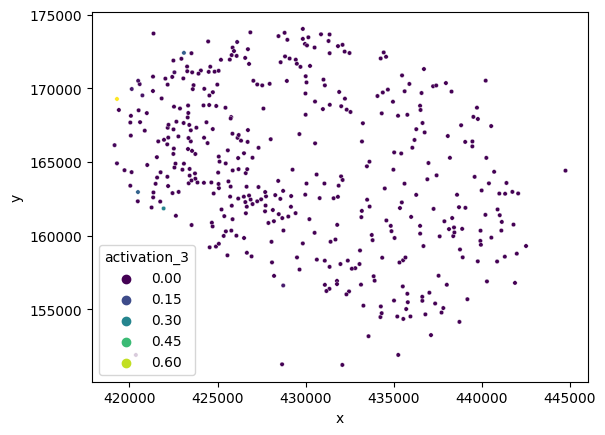

In [83]:
sns.scatterplot(data=head_propagation, x="x", y="y", hue="activation_3", palette="viridis", s=10)

In [86]:
head_propagation.to_csv("head_direction_propagation.csv", index=False)